<a href="https://colab.research.google.com/github/fdsig/iaqa/blob/main/visualize_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import auth
auth.authenticate_user()

In [4]:
%%capture 
# get dependacies 
!pip -q install vit_pytorch linformer
!rm -rf vit-pytorch/ && rm -rf image_utils
# to obtian AVA Dataset withough needing to dowload or mount your own drive
!git clone https://github.com/fdsig/image_utils
# moves image getter (ava data) into working directory
!mv image_utils/image_getter.py ./image_getter.py
!pip install timm
!pip uninstall albumentations -y
!pip install albumentations
!pip uninstall opencv-python-headless==4.5.5.62 -y
!pip install opencv-python-headless==4.5.2.52  
!pip install wandb -qqq
!pip install git+https://github.com/rwightman/pytorch-image-models.git

In [5]:
# wandb integration loging in at start
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
from google.colab import drive
def mount():
    #mount drive for saving results 
    #need to go through the usual authorization dance
    drive.flush_and_unmount()
    drive.mount('/content/drive', force_remount=True) 
mount()

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [7]:
!ls drive/MyDrive/ava_batches


Batch_0.zip   Batch_18.zip  Batch_26.zip  Batch_34.zip	Batch_42.zip
Batch_10.zip  Batch_19.zip  Batch_27.zip  Batch_35.zip	Batch_43.zip
Batch_11.zip  Batch_1.zip   Batch_28.zip  Batch_36.zip	Batch_4.zip
Batch_12.zip  Batch_20.zip  Batch_29.zip  Batch_37.zip	Batch_5.zip
Batch_13.zip  Batch_21.zip  Batch_2.zip   Batch_38.zip	Batch_6.zip
Batch_14.zip  Batch_22.zip  Batch_30.zip  Batch_39.zip	Batch_7.zip
Batch_15.zip  Batch_23.zip  Batch_31.zip  Batch_3.zip	Batch_8.zip
Batch_16.zip  Batch_24.zip  Batch_32.zip  Batch_40.zip	Batch_9.zip
Batch_17.zip  Batch_25.zip  Batch_33.zip  Batch_41.zip


In [8]:
from __future__ import print_function
import json
import cv2
import glob
from itertools import chain
import os
import pandas as pd
import random
# file handling
import zipfile
import shutil
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
from vit_pytorch.efficient import ViT
from sklearn.utils import class_weight
import time
import copy
from sklearn.preprocessing import LabelEncoder

#
import timm
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer

from albumentations import pytorch
from pathlib import Path
import torchvision
import gc
from pathlib import Path

from sklearn import metrics
from vit_pytorch.cvt import CvT


In [9]:
# equivalent to:
#!cp -r drive/MyDrive/ava_batches_demo batches
origionals = Path('drive/MyDrive/ava_batches/')
target = Path('batches/')
if not target.exists():
  target.mkdir()
fids = [fid for fid in origionals.iterdir()]
for fid in tqdm(fids,colour=("#FF69B4")):
  shutil.copy(fid.as_posix(),target/fid.name)


100%|██████████| 44/44 [10:41<00:00, 14.58s/it]


In [10]:
paths = [i for i in os.scandir('batches')]
for zip_f in tqdm(paths, colour=("#FF69B4")):
                zip_ref = zipfile.ZipFile(zip_f, "r")
                zip_ref.extractall("./Images/")
                zip_ref.close()
                os.remove(zip_f)

      

root = Path("Images")
images = [file for folder in root.iterdir() for file in folder.iterdir()]
print(images[0].name)
for img in images:
  img.rename(root/img.name)

for i in root.iterdir():
  if i.is_dir():
    i.rmdir()


100%|██████████| 44/44 [04:36<00:00,  6.29s/it]


55020.jpg


In [68]:
from matplotlib import rcParams
def scalar_resize(fid,scalar=None):
    img = cv2.imread(fid.path, cv2.IMREAD_UNCHANGED)
    shape = np.array(img.shape)
    scalar = scalar/shape[shape.argmax()]
    shape = np.ceil(shape*scalar).astype(int)
    dim = (shape[1], shape[0])
    # resize image
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def get_df():
    df = pd.read_csv('/content/image_utils/ava_meta_with_int_id_230721.csv')
    display(df)
    plt.hist(df['MLS'].values.ravel(), bins=10)
    plt.show()
    return df

def meta_process(df=None):
    y_gt = df['mos_float'].values
    ids = df['ID'].values
    print(len(ids))
    y_gt_std, y_gt_mean = np.std(y_gt, axis = 0), np.mean(y_gt, axis = 0)
    exclude_below = y_gt_mean-y_gt_std*4
    exclude_above = y_gt_mean+y_gt_std*4
    ids = ids[np.argwhere(y_gt>=exclude_below)].ravel()
    y_gt = y_gt[np.argwhere(y_gt>=exclude_below)].ravel()
    print(len(y_gt))
    ids = ids[np.argwhere(y_gt<=exclude_above)].ravel()
    y_gt = y_gt[np.argwhere(y_gt<=exclude_above)].ravel()
    print(len(ids),len(y_gt))
    ids_low = ids[np.argwhere(y_gt<5)].ravel().astype(int)
    ids_high = ids[np.argwhere(y_gt>5)].ravel().astype(int)
    to_include = np.concatenate((ids_low,ids_high), axis=0)
    len(to_include)
    return df[df['ID'].isin(to_include)]


def one_hot(df):
    one_hot = pd.get_dummies(df['MLS'])
    one_hot = pd.merge(df['ID'],one_hot, right_on=df.index, left_index=True)
    one_hot = one_hot[one_hot.columns[1:]]
    y_df = pd.merge(one_hot,df[['threshold', 'ID','MOS','MLS','set']], right_on=one_hot.index, left_index=True)
    return y_df[y_df.columns[2:]]



def sort_show():
    ava = [ i.path for i in os.scandir('Images/')]
    ava.sort()
    read = lambda fid: cv2.cvtColor(cv2.imread(fid), 
                                    cv2.COLOR_BGR2RGB)
    img = read(ava[0])
    print(img.shape)
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.imshow(img)


def get_labels(df):
    y_df = one_hot(df)
    labels = (
            fid.name.split('.')[0] 
            for path in os.scandir('Images/') 
            for fid in os.scandir(path.path))
    y_g = y_df.to_dict('index')
    return {str(y_g[pair_key]['ID_y']):y_g[pair_key] for pair_key in y_g}

def make_class_dir(df,y_g_dict):
    '''creates text train val with class subdirs
    
    ⌊_train
    |     ⌊_class 0
    |     ⌊_class 1
    ⌊_test
    |     ⌊_class 0
    |     ⌊_class 1
    ⌊_val_
          ⌊_class 0
          ⌊_class 1'''
    
    os.makedirs('data/', exist_ok=True)
    train_dir = 'data/train/'
    test_dir = 'data/test/'
    #!rm -rf data/train/ && rm -rf data/test/
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir,exist_ok=True)
    not_loaded_train, not_loaded = [ ], [ ]
    test_df = df[df['set']=='test']
    files_ = [i.name for i in os.scandir('Images/')]
    test_set = test_df['image_name'].values
    for im_id in tqdm(test_set, colour=('#FF69B4')):
        key = im_id.strip('.jpg')
        y_g_dict[key]['fid']='data/test/'+im_id
        try:
        
            os.symlink('Images/'+im_id,'data/test/'+im_id)
        except:
            not_loaded.append(im_id)
    train_df = df[df['set'].isin(['training','validation'])]
    train_set = train_df['image_name'].values
    for im_id in tqdm(train_set, colour=('#FF69B4')):
        key = im_id.strip('.jpg')
        y_g_dict[key]['fid']='data/train/'+im_id
        try:
        
            os.symlink('Images/'+im_id,'data/train/'+im_id)
        except:
            not_loaded_train.append(im_id)
            
    return y_g_dict
    

def class_wts(df):
    '''computes class weights for training samplere'''
    y_gt = df.values.ravel()
    y_gt_ = np.array(y_gt)
    y = np.bincount(y_gt_)
    x = np.unique(y_gt_)
    print(len(y),len(x))
    plt.bar(x,y)
    plt.show()
    class_weights=class_weight.compute_class_weight('balanced',classes=x,y=y_gt_)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    print(class_weights) 
    return class_weights, y

def image_plot(image_dict, eval_list=None, super_title = None, n_images=None, evaluate=None):
    '''plots random images'''
    rcParams['axes.titlepad'] = 10
    if not evaluate:
        random_keys = np.random.choice(
        list(image_dict.keys()), n_images, replace=False
        )
    if evaluate:
        eval_list = [
                     name.split('.')[0] for name in eval_list
                     ]
        random_keys = np.random.choice(
        eval_list, n_images, replace=False
        )
        

    cvt = lambda img: cv2.cvtColor(cv2.imread(img, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
    if random_keys.__class__==np.ndarray:
        fig, axes = plt.subplots(1,len(random_keys), figsize=(15,10))
        for idx, ax in enumerate(axes.ravel()):
            print(random_keys)
            img = cvt(os.readlink(image_dict[random_keys[idx]]['fid']))
            ax.axis("off")
            ax.set_yticks([])
            ax.set_xticks([])
            meta = image_dict[random_keys[idx]]
            title = f"ID:{random_keys[idx]} MOS:{meta['MOS']:.2f}"
            
            if meta['threshold'] ==1:
                cls_ = 0
            else:
                cls_ = 1
            title += f"\nBinary Class: {cls_}"
            ax.set_title(title, size=20)
            ax.imshow(img)
        fig.suptitle(super_title, fontsize=24)
        fig.savefig(super_title+'.png')
        plt.show()
    else:
    
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.axis("off")
        print(random_keys)
        img = cvt(os.readlink(image_dict[random_keys]['fid'])) 
        ax.set_yticks([])
        ax.set_xticks([])
        meta = image_dict[random_keys]
        title = f"ID:{random_keys} MOS:{meta['MOS']:.2f}"
        if meta['threshold'] ==1:
            cls_ = 0
        else:
            cls_ = 1
        title += f"\nBinary Class: {cls_}"
        title += f"\nBinary Class: {meta['threshold']}"
        ax.set_title(title, size=20)
        ax.imshow(img)
        fig.suptitle(super_title, fontsize=24)
        fig.savefig(super_title+'.png')
        plt.show()

def get_all():
    '''meta fucntion for calling other fuctions'''
    df = get_df()
    df = meta_process(df=df)
    class_weights, class_counts = class_wts(df['threshold'])
    y_g_dict = get_labels(df)
    make_class_dir(df,y_g_dict)
    y_g_neg = {key:y_g_dict[key] for key in y_g_dict if y_g_dict[key]['threshold']==0}
    y_g_pos = {key:y_g_dict[key] for key in y_g_dict if y_g_dict[key]['threshold']==1}
    sets = ['test', 'training', 'validation']
    splits ={
        set_: {
            im_key:y_g_dict[im_key] for im_key in y_g_dict 
            if y_g_dict[im_key]['set']==set_
            } for set_ in sets
            }
    print(f"train set n = {len(splits['training'])} \ntest_list n = {len(splits['test'])}\nvalidation_list n = {len(splits['validation'])}")
    return df, y_g_dict, splits, y_g_neg, y_g_pos

def data_transforms(size=None):
    '''defines data transform and returns a dict with test,train,val transforms'''
    mask1 = np.full(30 * 140, False) 
    a_train_transform = A.Compose(
        [
         A.augmentations.transforms.GridDistortion(
                num_steps=5, 
                distort_limit=0.6, 
                interpolation=1, 
                border_mode=4, 
                value=4, 
                mask_value=2, 
                always_apply=False, 
                p=0.1),
            A.augmentations.geometric.resize.LongestMaxSize(
                max_size=size
                ),
            A.augmentations.transforms.PadIfNeeded(size,size),
            A.augmentations.transforms.Normalize(
                mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225), 
                max_pixel_value=255.0, p=1.0),
            #A.augmentations.transforms.MedianBlur(blur_limit=7, always_apply=False, p=0.5)
            A.augmentations.transforms.CoarseDropout (max_holes=10, 
                                                      max_height=72, 
                                                      max_width=72, 
                                                    min_holes=3, 
                                                    min_height=36, 
                                                    min_width=36, 
                                                    fill_value=(random.uniform(0, 1),
                                                                random.uniform(0, 1), 
                                                                random.uniform(0, 1)) , 
                                                      mask_fill_value=(0.5,0.2,0.4), 
                                                      always_apply=False, p=0.1),
            A.augmentations.transforms.ColorJitter(brightness=0.05, 
                                                   contrast=0.05, 
                                                   saturation=0.05, 
                                                   hue=0.05, 
                                                   always_apply=False,
                                                   p=0.1),
            A.augmentations.transforms.Cutout(
                num_holes=8, 
                max_h_size=36, 
                max_w_size=36, 
                fill_value=(
                    random.uniform(0, 1),
                    random.uniform(0, 1), 
                    random.uniform(0, 1)
                    ),
                always_apply=False, 
                p=0.1
                ),
            A.augmentations.transforms.GaussianBlur(
                blur_limit=(3, 5), 
                sigma_limit=0, 
                always_apply=False, 
                p=0.1
                ),
            A.augmentations.transforms.GaussNoise(
                var_limit=(0.1, 0.1), 
                mean=0.1, 
                per_channel=True, 
                always_apply=False, 
                p=0.1
                ),
            A.augmentations.transforms.HueSaturationValue(
                hue_shift_limit=0.1, 
                sat_shift_limit=0.1, 
                val_shift_limit=0.1, 
                always_apply=False, 
                p=0.01
                ),
            A.augmentations.transforms.MotionBlur(
                blur_limit=3,p=0.2
                ),
            A.augmentations.geometric.rotate.SafeRotate(limit=30, 
                                                        interpolation=1, 
                                                        border_mode=4, 
                                                        value=None, 
                                                        mask_value=None, 
                                                        always_apply=False, 
                                                        p=0.1
                                                        ),
        
            A.pytorch.transforms.ToTensorV2(
                transpose_mask=False, p=1.0
                )
            ]
            )

    a_test_transform = A.Compose([
            A.augmentations.geometric.resize.LongestMaxSize(max_size=224),
            A.augmentations.transforms.PadIfNeeded(224,224),
            A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), 
                                                max_pixel_value=255.0, p=1.0),
                            A.pytorch.transforms.ToTensorV2(transpose_mask=False, p=1.0) ]
                            )



    a_valid_transform = A.Compose([
            A.augmentations.geometric.resize.LongestMaxSize(max_size=224),
            A.augmentations.transforms.PadIfNeeded(224,224),
            A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), 
                                                max_pixel_value=255.0, p=1.0),
                            A.pytorch.transforms.ToTensorV2(transpose_mask=False, p=1.0) ]
                            )
    return {'test':a_test_transform, 'training':a_train_transform , 'validation':a_valid_transform}




def plot_transform(data_dict):
    '''plots data transforms'''
    idx = 11
    read = lambda fid: cv2.cvtColor(cv2.imread(os.readlink(fid)), cv2.COLOR_BGR2RGB).astype(np.uint8)


    cvt = lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_fid = y_g_dict[list(y_g_dict.keys())[idx]]['fid']
    img = read(img_fid).astype(np.uint8)
    img_array = read(y_g_dict[list(y_g_dict.keys())[idx]]['fid'])

    #permute(1,2,0) permutes value of transfrom 'image' item from tesor to RGB 3 * 224 * 224
    refleciton_pad_array = reflect_transforms['training'](image=img)['image'].permute(1,2,0)

    print(img.shape)

    #zero_pad_array = train_transforms(Image.fromarray(img_array)).permute(1,2,0)
    fig, axs = plt.subplots(2,3, figsize=(15,15))
    no_transform_fid = read(img_fid)

    transforms_dict = {'no_tranform': no_transform_fid,
                'from_array': img_array,
                'reflection_from_Pad_array': refleciton_pad_array}
    for idx_ in range(3):
        img_fid = y_g_dict[list(y_g_dict.keys())[idx]]['fid']
        img = read(img_fid).astype(np.uint8)
        transforms_dict['reflect'+str(idx_)]=reflect_transforms['training'](image=img)['image'].permute(1,2,0)



    for item in enumerate(transforms_dict):
        idx, key = item
        if idx<3:
            row=0
        else:
            row=1
            idx-=3
        axs[row,idx].imshow(transforms_dict[key])
        axs[row,idx].set_title(key)
        axs[row,idx].set_ylabel(transforms_dict[key].shape[0])
        axs[row,idx].set_xlabel(transforms_dict[key].shape[1])
        if str(type(transforms_dict[key]))!="<class 'numpy.ndarray'>":
            print(type(transforms_dict[key]) )
            cv2.imwrite(key+'.png',transforms_dict[key].numpy().astype(np.uint8))
    plt.savefig('transfroms.png', dpi=300)

def data_samplers(data, data_class, batch_size=None):
    '''retrurns data loaders called during training'''
    test_ids = [idx for idx in data['training']][:20]
    # a small subset for debugging if needed <^_^> 
    data_tester = {key:data['training'][key] for key in test_ids}
    #change back

    train_data_loader =  ava_data_reflect(
        data['training'], transform=reflect_transforms['training']
        )
    val_data_loader =  ava_data_reflect(
        data['validation'], transform=reflect_transforms['validation']
        )
    test_data_loader =  ava_data_reflect(
        data['test'], transform=reflect_transforms['test']
        )
    data_load_dict = {
        'training':train_data_loader,
        'validation':val_data_loader, 
        'test': test_data_loader
        }
    #Let there be 9 samples and 1 sample in class 0 and 1 respectively
    labels = [data['training'][idx]['threshold'] for idx in data['training']]
    class_counts = np.bincount(labels)
    num_samples = sum(class_counts)
    #corresponding labels of samples
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]
    sampler = torch.utils.data.WeightedRandomSampler(
        torch.DoubleTensor(weights), int(num_samples)
        )
    print(len(weights))
    print(class_weights)
    sampler = torch.utils.data.WeightedRandomSampler(
        torch.DoubleTensor(weights), int(len(data['training'].keys()))
        )
    # with data sampler (note ->> must be same len[-,...,-] as train set!!)
    train_loader = DataLoader(
        dataset = train_data_loader, 
        sampler=sampler, 
        batch_size=batch_size,
        shuffle=False
        )

    val_loader = DataLoader(
        dataset = val_data_loader, 
        batch_size=batch_size, 
        shuffle=False
        )
    test_loader = DataLoader(
        dataset = test_data_loader,
         batch_size=batch_size, shuffle=True)
    return {'training':train_loader,'validation':val_loader, 'test': test_loader}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def train_model(model, criterion, 
                optimizer, 
                scheduler, 
                num_epochs=None, 
                model_name = None, 
                did = None,
                data = None):
    '''Training and validation loops- 1 loop == one epoch
    has a saving fuciton saving model on best epoch
    records total train time'''
    results = { }
    # pathlib path object --> most pythonic option. 
    did = Path(did)
    did = did/model_name
    os.makedirs(did,exist_ok=True)
    print(f'currently trianing {model_name}')
    print(f'{model_name} will be saved at {did/model_name}')
    since = time.time()
    # copy state dict for best model saving (training could make them worse)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            dataset_size = len(data[phase])
            print(dataset_size)
            if phase == 'training':
                model.train()   # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            print(phase)
            # Iterate over data.
            for inputs, labels,fid in tqdm(data_load_dict[phase]):
                #wandb.log({"examples" : [wandb.Image(im) for im in inputs]})
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'training':
                scheduler[0].step(scheduler[1])

            ballance = np.array([])
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            class_preds = outputs.argmax(dim=1) 
            batch_acc = metrics.balanced_accuracy_score(labels.cpu(), 
                                                         class_preds.cpu())
            ballance = np.append(ballance, batch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            key = 'epoch_'+str(epoch+1)+'_'+phase
            results[key]= {
                phase+' loss' : epoch_loss, 
                phase+' acc': float(epoch_acc.cpu()),
                phase+ ' ballance_acc':ballance.mean()
                }
            wandb.log({
                phase+' loss' : epoch_loss, 
                phase+' acc': float(epoch_acc.cpu()),
                phase+ ' ballance_acc':ballance.mean()
                })
            # w mode to overwirte existing json - reading and re writing 
            # in append modes can cause jsaon formatting issues
            # files are json for ease of loading to python dict in evaluation
            still_to_train = num_epochs - epoch
            save_fid = did/(model_name+f'_epoch_{10-still_to_train}.json')
            with open(save_fid, 'w') as handle:
                json.dump(results, handle)
            print(results)

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc 
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'epoch':epoch, 
                            'model_state_dict':model.state_dict(),
                            'optimizer_state_dict':optimizer.state_dict()
                            }, did/model_name)
                wandb.log({'best_epoch':epoch})
                print(f'Saving {model_name} in {did.name}')
                #model save

    time_elapsed = time.time() - since
    t_mins, t_seconds = time_elapsed // 60, time_elapsed % 60
    train_overall = {
        'mins':t_mins, 
        'seconds':t_seconds, 
        'best_acc': best_acc.cpu().tolist()
        }
    wandb.log(train_overall)
    print(f'training time = {train_overall}')
    with open(did/('train_overall'+'.json'), 'w') as handle:
        json.dump(train_overall, handle)


def loader(models):
    '''genrator for models when loooping through all models'''
    for mod in models:
        print(mod)
        if 'ResNet' in mod:
            loaded = torch.load(models[mod])
            res_n = models[mod].name.split('_')[-1]
            if '18' == res_n:
                model = torchvision.models.resnet18(pretrained=True)
            elif '50' == res_n:
                model = torchvision.models.resnet50(pretrained=True)
            else:
                model = torchvision.models.resnet152(pretrained=True)
            feature_in = model.fc.in_features
            model.fc = nn.Linear(feature_in, 2)
            model.load_state_dict(loaded['model_state_dict'])
        elif'ConViT' in mod:
            print(models[mod].parent.name)
            loaded = torch.load(models[mod])
            print(loaded.keys())
            model = timm.create_model(models[mod].name.strip(models[mod].suffix)
            , pretrained=True)
            model.head = nn.Linear(model.head.in_features,2,bias=True)
            if 'pth' in models[mod].name:
                model.load_state_dict(loaded['model'])
            else:
                model.load_state_dict(loaded['model'])
        elif 'CvT' in mod:
            loaded = torch.load(models[mod])
            model = CvT(
                        num_classes = 2,
                        s1_emb_dim = 64,      
                        s1_emb_kernel = 7,     
                        s1_emb_stride = 4,      
                        s1_proj_kernel = 3,     
                        s1_kv_proj_stride = 2,  
                        s1_heads = 1,         
                        s1_depth = 1,         
                        s1_mlp_mult = 4,        
                        s2_emb_dim = 192,      
                        s2_emb_kernel = 3,
                        s2_emb_stride = 2,
                        s2_proj_kernel = 3,
                        s2_kv_proj_stride = 2,
                        s2_heads = 3,
                        s2_depth = 2,
                        s2_mlp_mult = 4,
                        s3_emb_dim = 384,     
                        s3_emb_kernel = 3,
                        s3_emb_stride = 2,
                        s3_proj_kernel = 3,
                        s3_kv_proj_stride = 2,
                        s3_heads = 4,
                        s3_depth = 10,
                        s3_mlp_mult = 4,
                        dropout = 0.
                    )
            model.load_state_dict
            model.load_state_dict(loaded['model_state_dict'])
        elif 'mobilenet' in mod:
            print(mod)
            model = timm.create_model(mod , pretrained=True)
            model.classifier.out_featrues=2
        elif 'mobilevit' in mod:
            print(mod)
            model = timm.create_model(mod , pretrained=True)
            model.head.fc.out_features=2
        else:
            model = timm.create_model(mod , pretrained=True)
            model.head.fc.out_features=2
        
        yield model,models[mod]['epochs'],mod
            
def deep_eval(model):
    '''validatioan loop ruturns metrics dict for passed model'''
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    results_dict = { }
    with torch.no_grad():
        model.eval()
        for data, label, fid in tqdm(data_load_dict['test']):
            data = data.to(device)
            label = label.to(device)
            output = model(data)            
            sm = torch.nn.Softmax(dim=1)
            probabilities = sm(output)
            for dir_,prob,lab in zip(fid,probabilities,label):
                results_dict[dir_.split('/')[-1]]={ 
                    'class_probs':prob.cpu().tolist(), 
                    'pred_class': int(prob.argmax(dim=0).cpu()), 
                    'g_t_class': int(lab.cpu())}
            val_loss = criterion(output, label)
            acc = (output.argmax(dim=1) == label).float().mean()
            results_dict['test_accuracy']={'test_acc':float(acc.cpu())}
    return results_dict


In [69]:
class ava_data_reflect(Dataset):
    '''data class wich is used by data loader retruns transformed image '''
    def __init__(self, im_dict, state = None, transform=None):
        self.im_dict = im_dict
        self.transform = transform
        self.files  = list(im_dict.keys())
        self.state = state

    def __len__(self):
        self.filelength = len(self.im_dict.keys())
        return self.filelength

    def __getitem__(self, idx):
        #img_path = self.im_dict[self.files[idx]]['fid']
        # reads symbolic links from test val train dirs returns rgb array
        read = lambda fid: cv2.cvtColor(cv2.imread(os.readlink(fid)), cv2.COLOR_BGR2RGB).astype(np.uint8)
        img = self.im_dict[self.files[idx]]['fid']
        img = read(img)
        # stacks grayscale images 
        if len(img.shape) !=3:
            img = np.stack([np.copy(img) for i in range(3)], axis=2)
             
        #img = self.a_transform(image=img)['image']
        # converst to pillow image from arry
        # this is faster as open cv reads image 
        # faster than pillow
        # pillow also returns file read errors
        # for some image in ava dataset
        # cv2 does not. 
        #img = Image.fromarray(img.astype('uint8'), 'RGB')
        
        img_transformed = self.transform(image=img)['image']
        # gets one hot (binary) thresholded groud truth

        label = int(self.im_dict[self.files[idx]]['threshold'])

        # uncomment to check that lable and data loading correctly (debug)
        #print(label, self.im_dict[self.files[idx]])

        

        return img_transformed, label, self.im_dict[self.files[idx]]['fid']

,Unnamed: 0,Unnamed: 0.1,1,2,3,4,5,6,7,8,...,challenge_id,MOS,image_name,MLS,set,width,height,ID,threshold,mos_float
0,0,0,0,0,0,5,32,50,23,10,...,1396,6.112903,953417.jpg,6,training,781.0,699.0,953417,1,6.112903
1,1,1,0,3,2,3,13,40,35,21,...,1396,6.593750,953777.jpg,6,training,550.0,800.0,953777,1,6.593750
2,2,2,0,2,3,9,35,50,20,5,...,1396,5.796875,953756.jpg,6,training,800.0,594.0,953756,1,5.796875
3,3,3,0,1,7,26,56,23,6,1,...,1396,5.040984,954195.jpg,5,training,587.0,674.0,954195,1,5.040984
4,4,4,0,1,4,5,33,50,17,9,...,1396,5.943548,953903.jpg,6,training,800.0,533.0,953903,1,5.943548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255497,255497,255497,1,7,17,40,84,56,31,13,...,181,5.339844,56938.jpg,5,training,640.0,456.0,56938,1,5.339844
255498,255498,255498,1,0,8,25,50,65,55,26,...,181,6.235294,57304.jpg,6,training,583.0,640.0,57304,1,6.235294
255499,255499,255499,0,0,8,11,26,47,48,56,...,181,7.072581,56711.jpg,8,training,640.0,485.0,56711,1,7.072581
255500,255500,255500,0,2,19,30,75,60,30,25,...,181,5.608871,57303.jpg,5,training,640.0,423.0,57303,1,5.608871


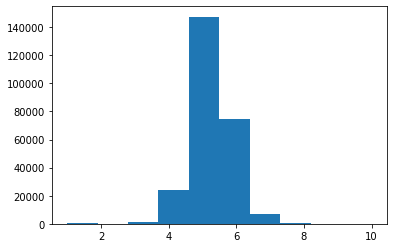

255502
255411
255403 255403
2 2


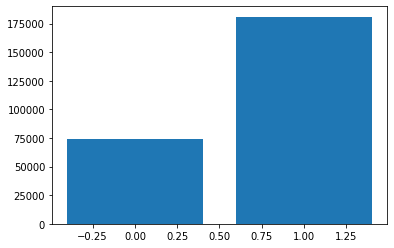

tensor([1.7220, 0.7046])


100%|██████████| 235121/235121 [00:04<00:00, 57072.22it/s]


train set n = 223363 
test_list n = 19899
validation_list n = 11758


In [70]:
df,y_g_dict, data, neg, pos = get_all()

In [15]:
!ls drive/MyDrive/mobilevit_xxs/mobilevit_xxs

drive/MyDrive/mobilevit_xxs/mobilevit_xxs


In [16]:
model = timm.create_model('mobilevit_xxs')

In [22]:
model.head.fc.out_features=2

In [26]:
loaded = torch.load('drive/MyDrive/mobilevit_xxs/mobilevit_xxs')

In [28]:
model.load_state_dict(loaded['model_state_dict'])

<All keys matched successfully>

In [32]:
a_test_transform = A.Compose([
            A.augmentations.geometric.resize.LongestMaxSize(max_size=224),
            A.augmentations.transforms.PadIfNeeded(224,224),
            A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), 
                                                max_pixel_value=255.0, p=1.0),
                            A.pytorch.transforms.ToTensorV2(transpose_mask=False, p=1.0) ]
                            )

In [104]:




def get_attention_map(x, get_mask=False):
    #x.size()

    with torch.no_grad():
        logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

In [105]:
reflect_transforms = data_transforms(size=224)

test_data_loader =  ava_data_reflect(
        data['test'], transform=reflect_transforms['test']
        )
test_loader = DataLoader(
        dataset = test_data_loader,
         batch_size=1, shuffle=False)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


IndexError: ignored

In [106]:
ldr = iter(test_data_loader)

In [119]:
data, lable, dir_ = next(ldr)
model = model.eval()
with torch.no_grad():
    model(data.unsqueeze(0))

In [136]:
model.stages.

<bound method Module.modules of Sequential(
  (0): Sequential(
    (0): BottleneckBlock(
      (shortcut): Identity()
      (conv1_1x1): ConvNormAct(
        (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv2_kxk): ConvNormAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv2b_kxk): Identity()
      (attn): Identity()
      (conv3_1x1): ConvNormAct(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_r

In [60]:
torch.tensor([1])

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

